In [54]:
import sys
sys.path.append('../')

import optim_utils

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [55]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [56]:
passes_df = pd.read_csv(PASSES_DF_PATH)

In [57]:
xt_table = pd.read_csv(XT_PLOT_PATH)
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
threat_map = optim_utils.ThreatMap(xt_table, pitch_length, pitch_width)

In [58]:
negative_frames = optim_utils.all_negative_dxt_frames(passes_df, threat_map)
passes_df = passes_df[~passes_df['frame'].isin(negative_frames)]

# Defender Evaluation

In [14]:
pass_results, agg_results = optim_utils.optimize_defender(passes_df, 10082, threat_map, pitch_length, pitch_width, radius=5, grid_res=20, mode='softmax')

In [15]:
agg_results

,improvement,improvement_perc,distance
mean,0.000127,70.847900,4.169720
median,0.000046,18.363326,4.838099
std,0.000257,265.159990,1.142007


# Apply to all defenders

In [16]:
player_ids = passes_df[~passes_df['tracking.is_ball']]['tracking.object_id'].unique()

In [17]:
def_passes = {}
def_stats = {}
def_counts = {}
for player_id in tqdm(player_ids):
    def_passes[player_id], def_stats[player_id] = optim_utils.optimize_defender(passes_df, player_id, threat_map, pitch_length, pitch_width, radius=5, grid_res=20, mode='softmax')
    def_counts[player_id] = len(def_passes[player_id])

  0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
results = pd.concat(def_stats).reset_index().rename(columns={'level_0': 'player_id', 'level_1': 'metric'})
means = results[results['metric'] == 'mean'].drop(columns='metric')
medians = results[results['metric'] == 'median'].drop(columns='metric')
stds = results[results['metric'] == 'std'].drop(columns='metric')
means['count'] = means['player_id'].map(def_counts)
medians['count'] = medians['player_id'].map(def_counts)
stds['count'] = stds['player_id'].map(def_counts)

## Average player improvement

In [66]:
means_filt = means[means['count'] >= 100]
medians_filt = medians[medians['count'] >= 100]

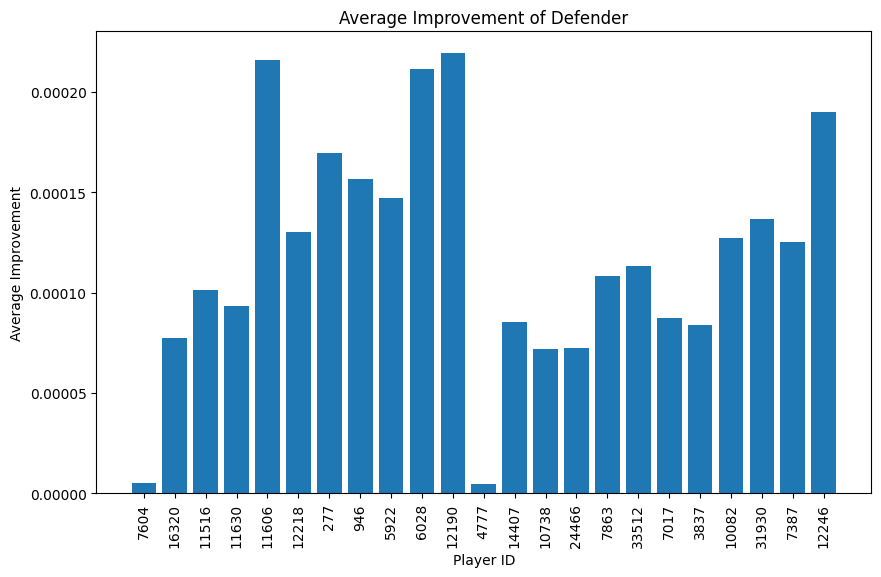

In [80]:
# plot bar chart of average defender improvement
plt.figure(figsize=(10, 6))
plt.bar(list(range(len(means_filt['improvement']))), means_filt['improvement'])
plt.xticks(list(range(len(means_filt['improvement']))), means_filt['player_id'], rotation=90)
plt.xlabel('Player ID')
plt.ylabel('Average Improvement')
plt.title('Average Improvement of Defender')
plt.show()

## Histogram of all improvement values

In [ ]:
improv_vals = pd.DataFrame()
for player_id in player_ids:
    player_improv = def_passes[player_id]['improvement']
    improv_vals = pd.concat([improv_vals, player_improv], axis=0)

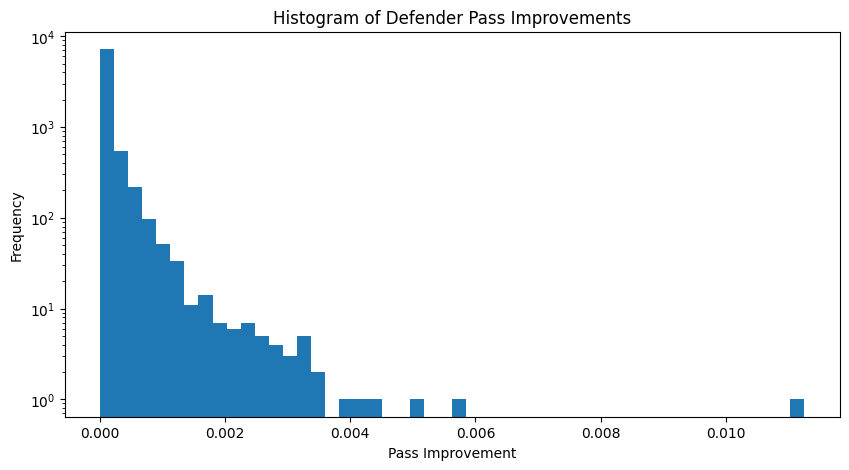

In [63]:
# plot histogram of defender pass improvements in log scale
plt.figure(figsize=(10, 5))
plt.hist(improv_vals, bins=50, log=True)
plt.xlabel('Pass Improvement')
plt.ylabel('Frequency')
plt.title('Histogram of Defender Pass Improvements')
plt.show()